# A Sequence Modeling Pipeline with PyTorch for Weather Prediction
# CENG501 - Spring 2023 - PA3

In this task, you are to follow a pipeline for training a recurrent network.

## 1 Import Modules

In [1]:
import pandas as pd
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors
import time                     # For measuring time
import random                   # Python's random library
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.autograd as autograd

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is not available :(


## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available at [https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx](https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$

  where $T_i$ is the temperature at hour index $i$.


In [3]:
# Write your code here
# If you like, you can create subsections here and split your code into
# meaningfully separate parts, e.g. "Loading the dataset", "Cleaning the dataset",
# "Splitting the dataset"..

# Load the Excel file and skip the first 10 rows
data = pd.read_excel('/content/Basel_weather.xlsx', header=None, skiprows=10) #content part can also written as ' https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx'

# Rename the columns
data.columns = ['Date', 'Temperature']

# Convert the first column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Reset the index and convert it to an hour index starting at 0
data.reset_index(drop=True, inplace=True)
data['Hour'] = np.arange(len(data))

# Split the data into training and test sets based on the specified dates
train_data = data[(data['Date'] >= '2021-06-01') & (data['Date'] <= '2021-06-16')]
test_data = data[(data['Date'] > '2021-06-16') & (data['Date'] <= '2021-06-23')]

# Slide a time window of six hours with a stride of 1 and create input-output pairs for the training set
window_size = 6
train_input = []
train_output = []

for i in range(len(train_data) - window_size):
    window = train_data['Temperature'].iloc[i:i + window_size -1].values
    target = train_data['Temperature'].iloc[i + window_size -1 ]
    train_input.append(window)
    train_output.append(target)

train_input = np.array(train_input)
train_output = np.array(train_output)

# input-output pairs for the test set
test_input = []
test_output = []

for i in range(len(test_data) - window_size):
    window = test_data['Temperature'].iloc[i:i + window_size -1].values
    target = test_data['Temperature'].iloc[i + window_size - 1]
    test_input.append(window)
    test_output.append(target)

test_input = np.array(test_input)
test_output = np.array(test_output)


# Reshape train_input and train_output
train_input = train_input.reshape(-1,window_size-1, 1)
train_output = train_output.reshape(-1, 1)
test_input = test_input.reshape(-1,window_size-1, 1)
test_output = test_output.reshape(-1,1)



# Create tensors from numpy arrays and make them double
train_input = torch.tensor(train_input, requires_grad=True, dtype=torch.double)
train_output = torch.tensor(train_output, requires_grad=True,  dtype=torch.double)
test_input = torch.tensor(test_input, requires_grad=True,  dtype=torch.double)
test_output = torch.tensor(test_output, requires_grad=True,  dtype=torch.double)


In [5]:
test_input.shape

torch.Size([162, 5, 1])

## 3 Your LSTM Definition

Implement your own LSTM "cell" using PyTorch without using PyTorch's LSTM implementation. However, you can use the backpropagation (gradient computation) mechanism of PyTorch and therefore, you just need to worry about feedforward processing.

Your implementation should not be limited to the weather prediction problem and be general. For the sake of simplicity, you can just implement a single-layer LSTM cell.

In [4]:
# Your LSTM Definition
class MyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        """
          input_size: the size of the input at a time step.
          hidden_size: the number of neurons in the hidden state.
        """
        super().__init__()

        ## @TODO: Create parameters in LSTM and initialize them
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize the weight matrices and bias vectors
        self.W_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size).double())
        self.W_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size).double())
        self.b_ih = nn.Parameter(torch.Tensor(4 * hidden_size).double())
        self.b_hh = nn.Parameter(torch.Tensor(4 * hidden_size).double())

        # Initialize the parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the weight matrices with Xavier initialization
        nn.init.xavier_uniform_(self.W_ih)
        nn.init.xavier_uniform_(self.W_hh)

        # Initialize the bias vectors with zeros
        nn.init.zeros_(self.b_ih)
        nn.init.zeros_(self.b_hh)

    def forward(self, X):
        """
          X: An input that has L time steps and for each time step, it has
          input_size many elements. Has shape (B, L, input_size) with B being
          the batch size.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps.
          Both have shape (B, L, hidden_size).
        """
        ## @TODO: Process X over L timesteps and return the output
        # Extract the batch size (B), Time steps (L), and input size (input_size)
        B, L, input_size = X.size()

        # Initialize the hidden state (h) and cell state (c) tensors with zeros
        h = torch.zeros(B, L, self.hidden_size).double().to(X.device)
        c = torch.zeros(B, L, self.hidden_size).double().to(X.device)

        # Iterate over each time step
        for t in range(L):
          # Get the input at the current time step
          x_t = X[:, t, :].double()

          # Compute the LSTM gates and cell state
          gates = x_t @ self.W_ih.t()
          gates += h[:, t - 1, :] @ self.W_hh.t()
          gates += self.b_ih
          gates += self.b_hh
          ingate, forgetgate, cellgate, outgate = torch.split(gates, self.hidden_size, dim=1)

          ingate = torch.sigmoid(ingate)
          forgetgate = torch.sigmoid(forgetgate)
          cellgate = torch.tanh(cellgate)
          outgate = torch.sigmoid(outgate)

          # Update the cell state (c) and hidden state (h) for the current time step
          c_t = (forgetgate * c[:, t - 1, :]) + (ingate * cellgate)
          h_t = outgate * torch.tanh(c_t)

          c = torch.cat((c[:, :t, :], c_t.unsqueeze(1), c[:, t + 1:, :]), dim=1)
          h = torch.cat((h[:, :t, :], h_t.unsqueeze(1), h[:, t + 1:, :]), dim=1)

        # Return the final hidden state (h) and cell state (c) tensors
        return h, c



In [6]:
# Create an instance of the MyLSTM class
input_size = 10
hidden_size = 20
lstm = MyLSTM(input_size, hidden_size)

# Generate random input data
batch_size = 32
sequence_length = 5
input_data = torch.randn(batch_size, sequence_length, input_size)

# Perform the forward pass
output_h, output_c = lstm(input_data)

# Print the output shapes
print("Output h shape:", output_h.shape)
print("Output c shape:", output_c.shape)

Output h shape: torch.Size([32, 5, 20])
Output c shape: torch.Size([32, 5, 20])


## 4 Your Sequence Model for Weather Prediction

In [7]:
class MyWeatherPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to
        # estimate
        # Create an instance of your LSTM model
        self.lstm = MyLSTM(input_dim, hidden_dim)

        # Create a fully connected (FC) layer
        self.fc = nn.Linear(hidden_dim, 1).double()

    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        # Forward pass through LSTM
        h, c = self.lstm(X)

        # Get the last hidden state
        last_hidden_state = h[:, -1, :].double()

        # Apply the FC layer
        prediction = self.fc(last_hidden_state).double()

        return prediction

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [8]:
def trainer_and_tester(model, train_input, train_output, test_input, test_output, criterion, optimizer, num_epochs, batch_size):
    # Enable anomaly detection
    autograd.set_detect_anomaly(True)
    # Create a list to store the loss history
    loss_history = []

    # Get the input size
    input_size = train_input.size(0)

    # Create tensors to store the predictions
    train_predictions = torch.empty(input_size, 1).to(device)
    test_predictions = torch.empty(test_input.size(0),1).to(device)

    for epoch in range(num_epochs):
        # Initialize the total loss for the current epoch
        total_loss = 0.0

        # Iterate over the training dataset in batches
        for i in range(0, input_size, batch_size):
            # Set the model in training mode
            model.train()

            # Get the current batch
            input_batch = train_input[i:i+batch_size]
            output_batch = train_output[i:i+batch_size]

            # Move the batch to the device
            input_batch = input_batch.double().to(device)
            output_batch = output_batch.double().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(input_batch)

            # Compute the loss
            loss = criterion(predictions, output_batch)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            total_loss += loss.item()

            # Store the predictions for the training set
            train_predictions[i:i+batch_size] = predictions.detach()

            # Set the model in evaluation mode for the test set
            model.eval()
            with torch.no_grad():
                # Forward pass on the test input
                test_predictions[i:i+batch_size] = model(test_input[i:i+batch_size].double().to(device)).detach()

        # Compute the average loss for the epoch
        avg_loss = total_loss / (input_size / batch_size)

        # Store the average loss in the loss history
        loss_history.append(avg_loss)

        # Print the average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    return loss_history, train_predictions, test_predictions


## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [9]:
# Your implementation comes here
import torch.optim as optim

# Set hyperparameters
learning_rate = 0.001
batch_size = 40
hidden_size = 128
num_epochs = 100

# Create an instance of the model
input_size = train_input.shape[2]
model = MyWeatherPredictor(input_size, hidden_size)

# Define a loss function
criterion = nn.MSELoss()

# Choose an optimizer (SGD with momentum)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Train the model
loss_history, train_predictions, test_predictions = trainer_and_tester(model, train_input, train_output, test_input, test_output, criterion, optimizer, num_epochs, batch_size)

Epoch 1/100, Loss: 176.514101
Epoch 2/100, Loss: 82.014703
Epoch 3/100, Loss: 18.574447
Epoch 4/100, Loss: 23.770093
Epoch 5/100, Loss: 17.362003
Epoch 6/100, Loss: 14.962933
Epoch 7/100, Loss: 16.886513
Epoch 8/100, Loss: 15.820762
Epoch 9/100, Loss: 15.235880
Epoch 10/100, Loss: 15.290116
Epoch 11/100, Loss: 14.974957
Epoch 12/100, Loss: 12.765361
Epoch 13/100, Loss: 13.319845
Epoch 14/100, Loss: 13.016498
Epoch 15/100, Loss: 10.457703
Epoch 16/100, Loss: 8.116232
Epoch 17/100, Loss: 8.226172
Epoch 18/100, Loss: 8.964789
Epoch 19/100, Loss: 8.728098
Epoch 20/100, Loss: 7.746519
Epoch 21/100, Loss: 6.788024
Epoch 22/100, Loss: 5.563754
Epoch 23/100, Loss: 4.651486
Epoch 24/100, Loss: 4.230387
Epoch 25/100, Loss: 4.099213
Epoch 26/100, Loss: 4.100957
Epoch 27/100, Loss: 4.098120
Epoch 28/100, Loss: 4.000270
Epoch 29/100, Loss: 3.787422
Epoch 30/100, Loss: 3.501571
Epoch 31/100, Loss: 3.197255
Epoch 32/100, Loss: 2.919600
Epoch 33/100, Loss: 2.693879
Epoch 34/100, Loss: 2.524907
Epoch 3

In [10]:
test_predictions.shape

torch.Size([162, 1])

In [11]:
train_predictions.shape

torch.Size([355, 1])

## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

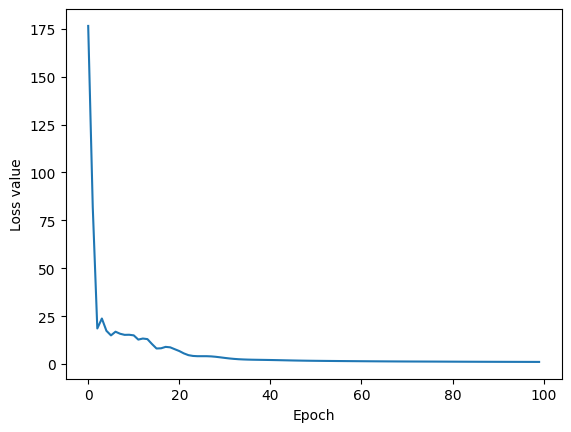

In [12]:
# Your implementation comes here

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

In [13]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [14]:
# My implementation

# Calculate the mean squared error (MSE) between predictions and test output
mse = criterion(test_predictions, test_output)

# Compute the root mean squared error (RMSE)
rmse = torch.sqrt(mse)

# Print the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmse.item():.6f}")

Root Mean Squared Error (RMSE): 1.355239


### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions:

(i) Slide a window on the test data, and plot the predictions only.

(ii) Use only the first window of the test data, let's denote this with $<T_0, T_{1}, T_{2}, T_{3}, T_{4}>$. After obtaining the first prediction $T'_{5}$ on this window, make your second prediction by sliding the window to include the new prediction, i.e., taking as input $<T_{1}, T_{2}, T_{3}, T_{4}, T_{5}'>$. Continue in this fashion to obtain the same number of predictions as the size of the test data.

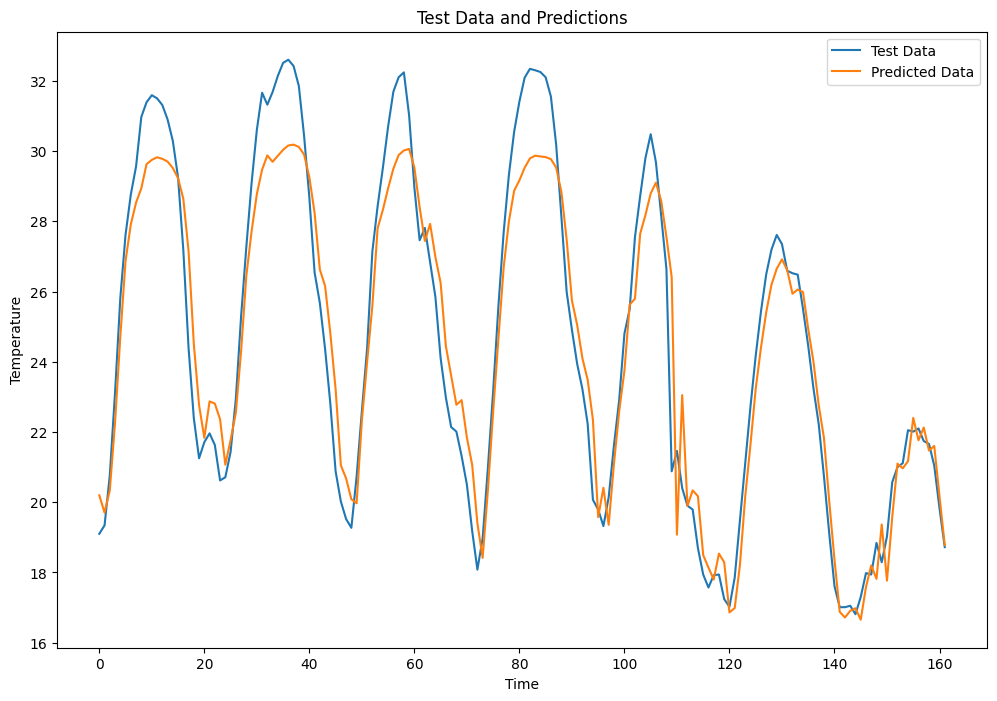

In [15]:
# (i)
import matplotlib.pyplot as plt

# Convert the tensors to numpy arrays
test_output_np = test_output.detach().squeeze().numpy()
test_predictions_np = test_predictions.detach().squeeze().numpy()

# Create a figure and axis object for the plot
fig, ax = plt.subplots()

# Plot the test data
ax.plot(range(len(test_output_np)), test_output_np, label='Test Data')
ax.plot(range(len(test_predictions_np)), test_predictions_np, label="Predicted Data")

# Add labels, title, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Test Data and Predictions')
ax.legend()

# Show the plot
plt.show()

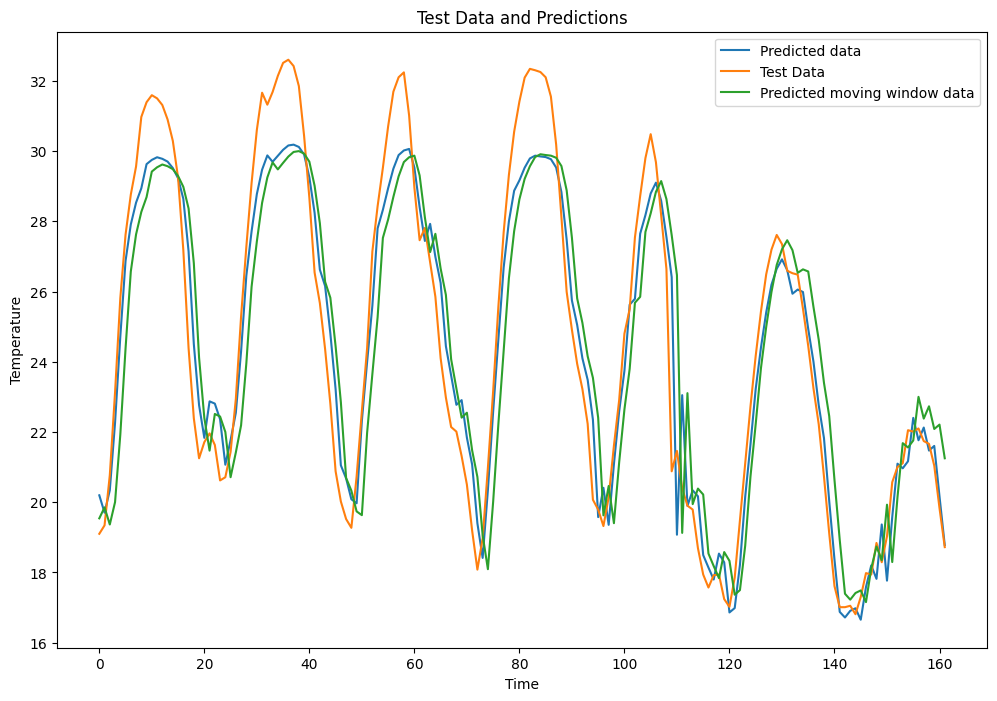

In [16]:
#(ii)
# My implementation

new_pred = torch.empty(test_input.size(0),1).to(device)
new_pred_np = new_pred.detach().squeeze().numpy()

model.eval()
test_input2 = test_input.clone()
test_input2 = test_input2.detach().numpy()
with torch.no_grad():
  for i in range(len(test_data) - window_size-1):
    new_pred[i:i+4] = model(test_input[i:i+4].double().to(device)).detach()
    test_input2[i+1][4] = new_pred[i].detach().numpy()

test_pred_plot = []
for i in range(len(test_data) - window_size):
  test_pred_plot.append(test_input2[i][4])


fig, ax = plt.subplots()
ax.plot(range(len(test_predictions_np)), test_predictions_np, label="Predicted data")
ax.plot(range(len(test_output)), test_output.detach().numpy(), label='Test Data')
ax.plot(range(len(test_pred_plot)), test_pred_plot, label="Predicted moving window data")

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Test Data and Predictions')
ax.legend()

# Show the plot
plt.show()

In [17]:
test_predictions

tensor([[20.1965],
        [19.7014],
        [20.3398],
        [22.2644],
        [24.7139],
        [26.8717],
        [27.9106],
        [28.5310],
        [28.9383],
        [29.6270],
        [29.7478],
        [29.8231],
        [29.7788],
        [29.6996],
        [29.5168],
        [29.2252],
        [28.6401],
        [27.1459],
        [24.5032],
        [22.7632],
        [21.8331],
        [22.8719],
        [22.8080],
        [22.3603],
        [21.0680],
        [21.7672],
        [22.5462],
        [24.2976],
        [26.4496],
        [27.7130],
        [28.7733],
        [29.4683],
        [29.8756],
        [29.6937],
        [29.8662],
        [30.0352],
        [30.1588],
        [30.1823],
        [30.1164],
        [29.9014],
        [29.2542],
        [28.2397],
        [26.6226],
        [26.1557],
        [24.8054],
        [23.2182],
        [21.0504],
        [20.6772],
        [20.0849],
        [19.9687],
        [22.3191],
        [23.9918],
        [25.

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.

In [18]:
import torch

def evaluate(prediction, test_output):

  # Calculate the mean squared error (MSE) between predictions and test output
  mse = criterion(prediction, test_output)

  # Compute the root mean squared error (RMSE)
  rmse = torch.sqrt(mse)

  return rmse.item()

In [19]:
import torch
import torch.optim as optim
# We create the fine tuning instance of the model.
input_size_best = train_input.shape[2]
hidden_neurons = [32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
momentum_var = [0.5, 0.7, 0.9]
num_epochs = 50

best_rmse = float('inf')
best_model = None
best_hidden_size = None
best_lr = None
best_momentum = None
best_batch_size = None
best_loss = []

for hidden_size in hidden_neurons:
  for lr in learning_rates:
    for p in momentum_var:
      for batch_size in batch_sizes:
          print(f"Current batch size, momentum, learning rate, hidden neuron size: {batch_size,p,lr,hidden_size}")
          # Create an instance of the model
          model_total = MyWeatherPredictor(input_size_best, hidden_size)
          model_total = model_total.to(device)

          # Optimizer with tuned momentum and learing rate
          optimizer_total = optim.SGD(model_total.parameters(), lr=lr, momentum=p)

          # loss criterion
          criterion_best = nn.MSELoss()

          # Train-tune the model and compute RMSE on the test set
          loss_historys, train_prediction, test_prediction = trainer_and_tester(model_total, train_input, train_output, test_input, test_output, criterion_best, optimizer_total, num_epochs, batch_size)
          rmse = evaluate(test_prediction, test_output)

          # Update the best model if the current RMSE is lower
          if rmse < best_rmse:
              best_rmse = rmse
              best_model = model_total
              best_hidden_size = hidden_size
              best_lr = lr
              best_momentum = p
              best_batch_size = batch_size
              best_loss = loss_historys

# Print the performance of the best model
print(f"Best RMSE: {best_rmse}")
print(f"Best Hidden Neurons: {best_hidden_size}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Momentum: {best_momentum}")
print(f"Best Batch Size: {best_batch_size}")

# Save the best model
torch.save(best_model.state_dict(), 'best_model.pth')

Current batch size, momentum, learning rate, hidden neuron size: (16, 0.5, 0.001, 32)
Epoch 1/50, Loss: 190.748612
Epoch 2/50, Loss: 21.556932
Epoch 3/50, Loss: 16.552144
Epoch 4/50, Loss: 16.305529
Epoch 5/50, Loss: 13.141536
Epoch 6/50, Loss: 12.049925
Epoch 7/50, Loss: 14.035051
Epoch 8/50, Loss: 11.192792
Epoch 9/50, Loss: 9.423240
Epoch 10/50, Loss: 8.998970
Epoch 11/50, Loss: 8.063867
Epoch 12/50, Loss: 8.153945
Epoch 13/50, Loss: 8.251366
Epoch 14/50, Loss: 6.947606
Epoch 15/50, Loss: 6.790067
Epoch 16/50, Loss: 6.594496
Epoch 17/50, Loss: 5.932704
Epoch 18/50, Loss: 5.964169
Epoch 19/50, Loss: 5.515425
Epoch 20/50, Loss: 5.201855
Epoch 21/50, Loss: 5.336726
Epoch 22/50, Loss: 4.816061
Epoch 23/50, Loss: 4.714208
Epoch 24/50, Loss: 4.531068
Epoch 25/50, Loss: 4.316602
Epoch 26/50, Loss: 4.099634
Epoch 27/50, Loss: 3.839776
Epoch 28/50, Loss: 3.714948
Epoch 29/50, Loss: 3.649117
Epoch 30/50, Loss: 3.506594
Epoch 31/50, Loss: 3.360586
Epoch 32/50, Loss: 3.223930
Epoch 33/50, Loss:

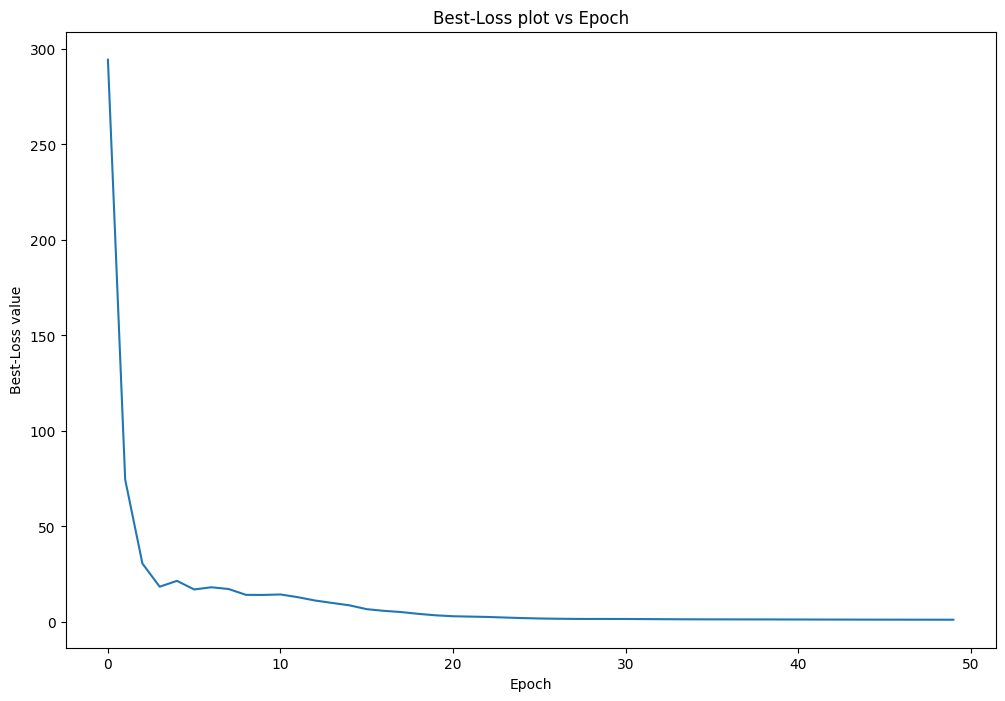

In [20]:
# best loss plot
plt.plot(best_loss)
plt.xlabel('Epoch')
plt.ylabel('Best-Loss value')
plt.title('Best-Loss plot vs Epoch')
plt.show()

In [21]:
# Initiate the best model

model_path = '/content/best_model.pth'

model_best = MyWeatherPredictor(input_size, best_hidden_size)

model_best.load_state_dict(torch.load(model_path))

model_best = model_best.to(device)

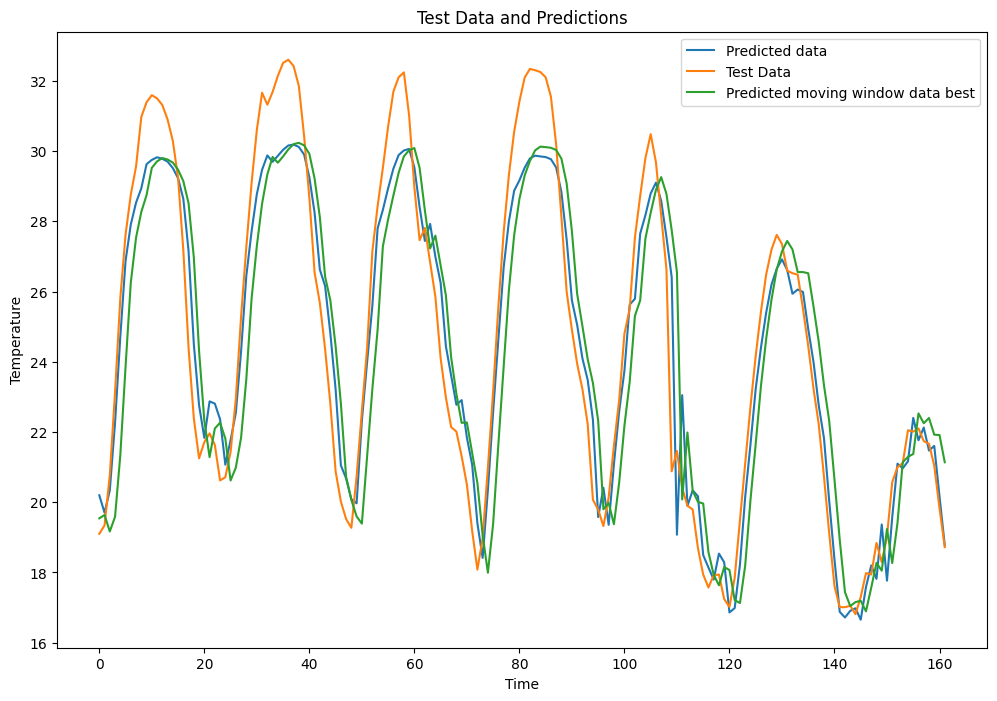

In [22]:
# (ii - for finetuning)

new_pred_best = torch.empty(test_input.size(0),1).to(device)
new_pred_best_np = new_pred_best.detach().squeeze().numpy()

model_best.eval()
test_input2_best = test_input.clone()
test_input2_best = test_input2_best.detach().numpy()
with torch.no_grad():
  for i in range(len(test_data) - window_size-1):
    new_pred_best[i:i+4] = model_best(test_input[i:i+4].double().to(device)).detach()
    test_input2_best[i+1][4] = new_pred_best[i].detach().numpy()

test_pred_plot_best = []
for i in range(len(test_data) - window_size):
  test_pred_plot_best.append(test_input2_best[i][4])


fig, ax = plt.subplots()
ax.plot(range(len(test_predictions_np)), test_predictions_np, label="Predicted data")
ax.plot(range(len(test_output)), test_output.detach().numpy(), label='Test Data')
ax.plot(range(len(test_pred_plot_best)), test_pred_plot_best, label="Predicted moving window data best")

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Test Data and Predictions')
ax.legend()

# Show the plot
plt.show()